In [1]:
!pip3 install torch torchvision torchaudio

In [1]:
import torch
import torch.nn as nn 
import os

In [2]:
import torchvision.models as models

In [3]:
resnet18 = models.resnet18(pretrained=True)

In [4]:
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [149]:
feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-1])
#feature_extractor
extracts =[]
for i in range(1,len(list(feature_extractor.children()))-4):
    features = nn.Sequential(*(list(feature_extractor.children())[4:i+4])) #second way
    extracts.append(features)


In [150]:
extracts

[Sequential(
   (0): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
 ),
 Sequential(
   (0): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64

In [151]:
initial = torch.nn.Sequential(*list(feature_extractor.children())[0:4])

In [11]:
for p in features.parameters():
    p.requires_grad = False

In [159]:
image_folder = "./Challenge_images"
imgs =os.listdir(image_folder)
from PIL import Image
import glob
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
image_list = []
for filename in glob.glob('Challenge_images*.jpg'): 
    im =Image.open(filename)
    im.show()
    

In [144]:
class embeddings():
    def __init__(self,image_paths,extracts,initializer):
        self.image_paths = image_paths
        self.ims = [Image.open(i) for i in image_paths]
        self.ims = [i.resize((416,416)) for i in self.ims]
        self.arrs =[np.array(j).reshape((1,3,416,416)) for j in self.ims]
        self.tensors =[torch.from_numpy(k)/255 for k in self.arrs]
        self.kernels = extracts
        self.initializer = initializer

    def get_features(self):
        self.starts =[]
        for t in self.tensors:
            self.start = self.initializer(t)
            self.starts.append(self.start)
        self.all_embeds =[]
        for s in self.starts:
            embeds =[]
            for e in self.kernels:
                ex = e(s)
                embeds.append(ex)
                
            self.all_embeds.append(embeds)
        return self.all_embeds
            
    


def reduction1(features):
    repss =[]
    for f in features:
        one =torch.norm(f, p=1, dim=3)
        two = torch.norm(one , p=1 , dim=2)
        r = int(512/(two.shape[1]))
        reps =two.repeat_interleave(r,dim=1)
        reps =reps.cpu().detach().numpy()
        repss.append(reps)
    repss = np.array(repss)
    means = repss.mean(axis=0)
    
    return means
    
    
        
    




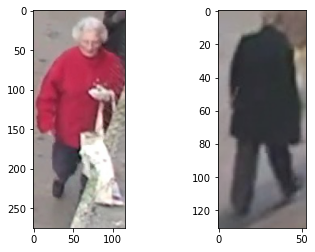

In [160]:
im1 =Image.open('Challenge_images/10.jpg')
im2 =Image.open('Challenge_images/0.jpg')
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1)
ax[1].imshow(im2)

In [152]:
feats =embeddings(['Challenge_images/0.jpg' ,'Challenge_images/10.jpg'] , extracts, initial)

In [153]:
embed1 =reduction1(feats.get_features()[0])
embed2 = reduction1(feats.get_features()[1])
cosine_similarity(embed1 , embed2)

array([[0.97426355]], dtype=float32)